In [1]:
import numpy as np
import pandas as pd
import os
import sys
from laser_core.propertyset import PropertySet
from laser_core.migration import gravity
from laser_core.migration import row_normalizer
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Exposure
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic import Births_ConstantPop_VariableBirthRate
from laser_generic import Infect_Random_Agents
from laser_generic.utils import set_initial_susceptibility_in_patch
from laser_generic.utils import seed_infections_in_patch
import pickle


data_dir = os.path.join('..', "data")
sys.path.append(data_dir)

from EnglandWalesmeasles import data as engwal
distances = np.load(os.path.join("..", "data", "EnglandWalesdistances.npy"))

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [2]:
average_pop = np.array([np.mean(place.population) for place in engwal.places.values()])
average_birthrate = np.array([np.mean(place.births/place.population) for place in engwal.places.values()])
average_cbr = 1000*np.sum(average_pop*average_birthrate)/np.sum(average_pop)
average_pop
average_cbr

17.190759545084912

In [6]:
# Compute the average birthrate across all places for each year
years = len(next(iter(engwal.places.values())).births)
births_matrix = np.array([place.births for place in engwal.places.values()])
pop_matrix = np.array([place.population for place in engwal.places.values()])
average_birthrate_per_year = np.sum(births_matrix, axis=0) / np.sum(pop_matrix, axis=0)
average_birthrate_per_year
varcbrs = {'rates': average_birthrate_per_year*1000, 'timesteps': np.arange(20*365, 41*365, 365)}

In [17]:
varcbrs

{'rates': array([20.02952833, 17.9144675 , 20.42631131, 21.36436433, 18.21985451,
        16.92059267, 15.88612325, 15.49023477, 15.33697828, 15.49216107,
        15.17054068, 14.9832194 , 15.64677526, 16.04860547, 16.37138672,
        16.43370987, 17.13950668, 17.60511266, 18.01245413, 18.19869286,
        18.52897008]),
 'timesteps': array([ 7300,  7665,  8030,  8395,  8760,  9125,  9490,  9855, 10220,
        10585, 10950, 11315, 11680, 12045, 12410, 12775, 13140, 13505,
        13870, 14235, 14600])}

In [ ]:
#For starters, we will work with a constant population and constant crude birth rate over the network.  
#This may prevent seeing some of the periodicity switch behavior, but we are focused on explicitly spatial stuff for now.
data = [{"name": placename,
         "population": place.population[0],
         "latitude": place.latitude,
         "longitude": place.longitude} for placename, place in engwal.places.items()]

scenario = pd.DataFrame(data)
parameters = PropertySet(
    {"seed": 4, "nticks": 20*365,
    "exp_shape": 40, "exp_scale": 0.25,
    "verbose": True, "beta": 1.2, "inf_mean": 10, "inf_sigma": 2, "cbr": average_cbr,
    "seasonality_factor": 0.2, "seasonality_phase": 182,
    "importation_period": 30, "importation_count": 3, "importation_start": 1, "importation_end": 8*365}
)

model = Model(scenario, parameters)
model.components = [
    Births_ConstantPop,
    Susceptibility,
    Transmission,
    Exposure,
    Infection,
    Infect_Random_Agents,
]

model.patches.network = row_normalizer(gravity(np.array(scenario.population), distances, 1e-8, 0, 1, 2), 0.2)

mu = (1 + parameters.cbr / 1000) ** (1 / 365) - 1
R0 = parameters.beta / (mu + 1 / parameters.inf_mean)
for i in range(len(model.patches)):
    set_initial_susceptibility_in_patch(model, i, 1 / R0 + 0.02 * np.random.normal())

seed_infections_in_patch(model, ipatch=0, ninfections=3)
#model.run()

2025-05-16 22:06:40.894037: Creating the generic model…
Initializing the generic model with 954 patches…


In [4]:
plt.plot(np.log10(model.patches.populations[0,:]), np.sum(model.patches.cases_test[3650:,:] == 0, axis=0)/((model.patches.cases_test.shape[0]-3650)), '.')
plt.xlabel('Population')
plt.ylabel('Sum of Entries (Cases == 0)')
plt.title('Population vs Sum of Entries where Cases == 0')
plt.show()

In [42]:
# Test equality for cases
#cases_equal = np.array_equal(model.patches.cases, model.patches.cases_test[:-1, :])

# Test equality for susceptibility
#susceptibility_equal = np.array_equal(model.patches.susceptibility, model.patches.susceptibility_test[:-1, :])

# Test equality for recovered
#recovered_equal = np.array_equal(model.patches.recovered, model.patches.recovered_test[:-1, :])

# Test equality for exposed
#exposed_equal = np.array_equal(model.patches.exposed, model.patches.exposed_test[:-1, :])

#cases_equal, susceptibility_equal, recovered_equal, exposed_equal

In [106]:
%%capture
data = [{"name": placename,
         "population": place.population[0],
         "latitude": place.latitude,
         "longitude": place.longitude} for placename, place in engwal.places.items()]
scenario = pd.DataFrame(data)
log_betas = np.array([0.155, 0.571, 0.46, 0.34, 0.30, 0.34, 0.24, 0.15, 0.31, 0.40, 0.323, 0.238, 0.202, 0.203, 0.074,
-0.095, -0.218, -0.031, 0.433, 0.531, 0.479, 0.397, 0.444, 0.411, 0.291, 0.509])


#Round 2
ks = 10**(np.random.uniform(-3, -1.5, 100))
bs = np.random.uniform(0.3, 0.8, 100)
cs = np.random.uniform(1.0, 2.0, 100)
betas = np.random.uniform(0.3, 1.8, 100)
params_df = pd.DataFrame({
    "k": ks,
    "b": bs,
    "c": cs
})
params_df.to_csv(os.path.join('..', 'outputs3', 'params.csv'), index=False)
for ind in range(len(ks)):
    k = ks[ind]
    b = bs[ind]
    c = cs[ind]
    parameters = PropertySet(
        {"seed": 4, "nticks": 40*365,
        "exp_shape": 40, "exp_scale": 0.25,
        "verbose": True, "beta": 3.4, "inf_mean": 8, "inf_sigma": 2, "cbr": 20,
        "biweekly_beta_scalar": np.exp(0.6*(log_betas - np.mean(log_betas))),
        "importation_period": 30, "importation_count": 3, "importation_start": 1, "importation_end": 10*365
        }
    )

    model = Model(scenario, parameters)
    model.components = [
        Births_ConstantPop,
        Susceptibility,
        Transmission,
        Exposure,
        Infection,
        Infect_Random_Agents,
    ]

    model.patches.network = gravity(np.array(scenario.population), distances, 1, 0, b, c)
    rowsums = np.sum(model.patches.network, axis=1)
    model.patches.network = model.patches.network / rowsums[:, np.newaxis] * k
    model.patches.network = row_normalizer(model.patches.network, 0.2)

    mu = (1 + parameters.cbr / 1000) ** (1 / 365) - 1
    R0 = parameters.beta / (mu + 1 / parameters.inf_mean)
    for i in range(len(model.patches)):
        set_initial_susceptibility_in_patch(model, i, 1 / R0 + 0.2/R0 * np.random.normal())

    seed_infections_in_patch(model, ipatch=507, ninfections=3)
    model.run()
    output_path = os.path.join('..', 'outputs3', f"EWoutputs_gravity_{int(ind)}.pkl")
    for attr in ['cases', 'susceptibility', 'exposed', 'recovered']:
        if hasattr(model.patches, attr):
            delattr(model.patches, attr)
    with open(output_path, "wb") as file:
        pickle.dump(model.patches, file)


Bad pipe message: %s [b'\xffI\x82\x99\xab\xab\xb3\x88T\xc9?\x82\x06`\x1e\x83\xa0\xeb\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r']
Bad pipe message: %s [b'9\xeb\x9c:\xb0Z\xd3\x11#R\xdd\x08s\x01M\xd8\x9cY\x00\x01|\x00\x00\x00\x01\x00\x02

array([1.00000000e-09, 1.37382380e-09, 1.88739182e-09, 2.59294380e-09,
       3.56224789e-09, 4.89390092e-09, 6.72335754e-09, 9.23670857e-09,
       1.26896100e-08, 1.74332882e-08, 2.39502662e-08, 3.29034456e-08,
       4.52035366e-08, 6.21016942e-08, 8.53167852e-08, 1.17210230e-07,
       1.61026203e-07, 2.21221629e-07, 3.03919538e-07, 4.17531894e-07,
       5.73615251e-07, 7.88046282e-07, 1.08263673e-06, 1.48735211e-06,
       2.04335972e-06, 2.80721620e-06, 3.85662042e-06, 5.29831691e-06,
       7.27895384e-06, 1.00000000e-05])

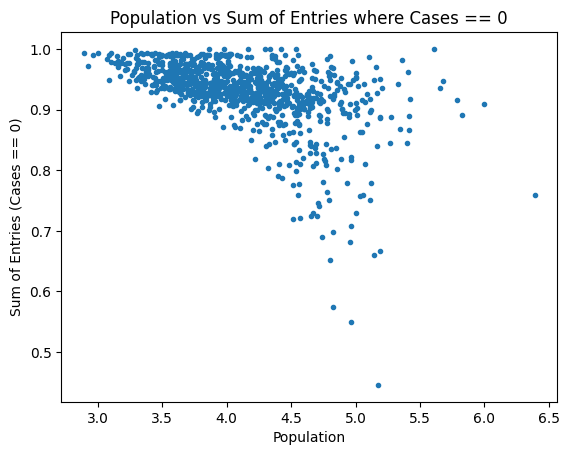

In [67]:
plt.plot(x.cases_test[:, 507], label="Susceptibility")
plt.xlim(12500, 13000)

(12500.0, 13000.0)

30182538

In [116]:
data = [{"name": placename,
         "population": place.population[0],
         "latitude": place.latitude,
         "longitude": place.longitude} for placename, place in engwal.places.items()]

scenario = pd.DataFrame(data)
network = row_normalizer(gravity(np.array(scenario.population), distances, 1e-4, 0, 1, 2).T, 0.2).T


In [117]:
plt.figure(figsize=(10, 8))
plt.imshow(np.log10(network), cmap='viridis', aspect='auto')
plt.colorbar(label='Connection Strength')
plt.title('Network Matrix Visualization')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_18666/3907757234.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(network), cmap='viridis', aspect='auto')


In [118]:
transfer = (x.cases_test[10000, :].copy().astype(np.float32))*network


In [112]:
np.unravel_index(np.argmax(transfer), transfer.shape)

(797, 233)

In [126]:
network = row_normalizer(gravity(np.array(scenario.population), distances, 1e-4, 0, 1, 2).T, 0.999).T
transfer = (x.cases_test[10000, :].copy().astype(np.float32))*network
any((x.cases_test[10000, :]-transfer.sum(axis=0))<0)

False

In [13]:
pops = np.array([10., 100., 1000.])
distances = np.array([[0., 1., 2.], [1, 0, 5], [2, 5, 0]])
network = gravity(pops, distances, 1, 0, 1, 1)

In [14]:
network

array([[  0., 100., 500.],
       [ 10.,   0., 200.],
       [  5.,  20.,   0.]])

In [15]:
row_normalizer(network, 0.5)

array([[0.        , 0.08333333, 0.41666667],
       [0.02380952, 0.        , 0.47619048],
       [0.1       , 0.4       , 0.        ]])

In [16]:
cases = np.array([1., 2, 3])

In [32]:
transfer = cases*network

In [33]:
transfer

array([[0.        , 0.16666667, 1.25      ],
       [0.02380952, 0.        , 1.42857143],
       [0.1       , 0.8       , 0.        ]])

In [34]:
transfer[0,1]

0.16666666666666666

In [36]:
cases[0]*network[0,1]

0.08333333333333333

In [12]:
cases.shape

(3,)

In [39]:
model.patches.cases_test[25, :].shape

(954,)

In [8]:
np.sqrt(3)

1.7320508075688772

In [9]:
3**(0.5)

1.7320508075688772

In [ ]:
model.patches.

In [10]:
.017*3e7

510000.00000000006

In [103]:
#For starters, we will work with a constant population and constant crude birth rate over the network.  
#This may prevent seeing some of the periodicity switch behavior, but we are focused on explicitly spatial stuff for now.
#test_outs = []
myparams = []
#for i in range(6, 11):
#    for j in range(5):
j=0
for i in range (20):
    beta = 3.4
    scalar = 0.6
    myparams.append((beta, scalar))
    data = [{"name": placename,
            "population": place.population[0],
            "latitude": place.latitude,
            "longitude": place.longitude} for placename, place in engwal.places.items()]

    log_betas = np.array([0.155, 0.571, 0.46, 0.34, 0.30, 0.34, 0.24, 0.15, 0.31, 0.40, 0.323, 0.238, 0.202, 0.203, 0.074,
    -0.095, -0.218, -0.031, 0.433, 0.531, 0.479, 0.397, 0.444, 0.411, 0.291, 0.509])

    scenario = pd.DataFrame(data)
    parameters = PropertySet(
        {"seed": i, "nticks": 40*365,
        "exp_shape": 40, "exp_scale": 0.25,
        "verbose": True, "beta": beta, "inf_mean": 8, "inf_sigma": 2, "cbr": 20,
        "biweekly_beta_scalar": np.exp( scalar*(log_betas - np.mean(log_betas)) ),
        "importation_period": 30, "importation_count": 3, "importation_start": 1, "importation_end": 10*365}
    )

    model = Model(scenario, parameters)
    model.components = [
        Births_ConstantPop,
        Susceptibility,
        Transmission,
        Exposure,
        Infection,
        Infect_Random_Agents,
    ]
    model.patches.network = gravity(np.array(scenario.population), distances, 1, 0, 0.6, 1.2)
    rowsums = np.sum(model.patches.network, axis=1)
    model.patches.network = model.patches.network / rowsums[:, np.newaxis] * 6e-3
    model.patches.network = row_normalizer(model.patches.network, 0.2)

    mu = (1 + parameters.cbr/ 1000) ** (1 / 365) - 1
    R0 = parameters.beta / (mu + 1 / parameters.inf_mean)
    for p in range(len(model.patches)):
        set_initial_susceptibility_in_patch(model, p, 1 / R0 + 0.2/R0 * np.random.normal())

    seed_infections_in_patch(model, ipatch=507, ninfections=3)
    model.run()
    #test_outs.append(model.patches.cases_test)
    #myparams.append((0.5+i/5, 0.5+0.25*j))

    output_path = os.path.join('..', 'periodicity_outs', f"EWoutputs3_betas_{i}_{j}.pkl")
    for attr in ['cases', 'susceptibility', 'exposed', 'recovered']:
        if hasattr(model.patches, attr):
            delattr(model.patches, attr)
    with open(output_path, "wb") as file:
        pickle.dump(model.patches, file)


2025-05-21 23:01:00.251048: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-21 23:01:08.400235: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:55<00:00, 35.16it/s]

Completed the generic model at 2025-05-21 23:08:03.616234…
Susceptibility_census:       330,040 µs
Transmission_census  :       114,844 µs
Exposure_census      :       150,616 µs
Infection_census     :       364,282 µs
Model                :       100,846 µs
Births_ConstantPop   :    27,926,638 µs
Susceptibility       :        29,408 µs
Transmission         :   343,794,114 µs
Exposure             :   230,634,780 µs
Infection            :   209,148,692 µs
Infect_Random_Agents :    13,618,068 µs
Total:                   826,212,328 microseconds
2025-05-21 23:08:03.814262: Creating the generic model…
Initializing the generic model with 954 patches…


2025-05-21 23:08:11.651916: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:38<00:00, 36.63it/s]


Completed the generic model at 2025-05-21 23:14:50.218472…
Susceptibility_census:       324,236 µs
Transmission_census  :       104,286 µs
Exposure_census      :       162,944 µs
Infection_census     :       356,730 µs
Model                :       100,372 µs
Births_ConstantPop   :    25,680,820 µs
Susceptibility       :        28,676 µs
Transmission         :   344,941,958 µs
Exposure             :   219,339,698 µs
Infection            :   187,940,862 µs
Infect_Random_Agents :    13,708,218 µs
Total:                   792,688,800 microseconds
2025-05-21 23:14:50.570758: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-21 23:14:58.650678: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:36<00:00, 36.85it/s]


Completed the generic model at 2025-05-21 23:21:34.820195…
Susceptibility_census:       336,356 µs
Transmission_census  :       122,822 µs
Exposure_census      :       137,986 µs
Infection_census     :       355,654 µs
Model                :       103,060 µs
Births_ConstantPop   :    23,909,204 µs
Susceptibility       :        29,932 µs
Transmission         :   333,747,256 µs
Exposure             :   216,036,956 µs
Infection            :   199,828,584 µs
Infect_Random_Agents :    13,597,816 µs
Total:                   788,205,626 microseconds
2025-05-21 23:21:35.129046: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-21 23:21:42.704547: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:41<00:00, 36.39it/s]


Completed the generic model at 2025-05-21 23:28:23.892438…
Susceptibility_census:       292,722 µs
Transmission_census  :       109,330 µs
Exposure_census      :       131,450 µs
Infection_census     :       358,634 µs
Model                :        95,026 µs
Births_ConstantPop   :    31,244,682 µs
Susceptibility       :        26,440 µs
Transmission         :   338,212,682 µs
Exposure             :   217,120,868 µs
Infection            :   197,711,050 µs
Infect_Random_Agents :    13,454,350 µs
Total:                   798,757,234 microseconds
2025-05-21 23:28:24.282148: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-21 23:28:31.782761: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:47<00:00, 35.82it/s]


Completed the generic model at 2025-05-21 23:35:19.356812…
Susceptibility_census:       291,204 µs
Transmission_census  :       108,528 µs
Exposure_census      :       123,664 µs
Infection_census     :       359,190 µs
Model                :        90,286 µs
Births_ConstantPop   :    32,444,234 µs
Susceptibility       :        26,888 µs
Transmission         :   341,701,894 µs
Exposure             :   222,489,918 µs
Infection            :   200,397,978 µs
Infect_Random_Agents :    13,490,472 µs
Total:                   811,524,256 microseconds
2025-05-21 23:35:19.705156: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-21 23:35:27.199881: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:41<00:00, 36.37it/s]


Completed the generic model at 2025-05-21 23:42:08.597393…
Susceptibility_census:       349,214 µs
Transmission_census  :       106,316 µs
Exposure_census      :       120,188 µs
Infection_census     :       349,942 µs
Model                :        87,120 µs
Births_ConstantPop   :    32,321,848 µs
Susceptibility       :        26,158 µs
Transmission         :   338,633,396 µs
Exposure             :   217,519,122 µs
Infection            :   196,365,346 µs
Infect_Random_Agents :    13,378,408 µs
Total:                   799,257,058 microseconds
2025-05-21 23:42:08.974282: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-21 23:42:16.568389: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:27<00:00, 37.65it/s]


Completed the generic model at 2025-05-21 23:48:44.317221…
Susceptibility_census:       285,610 µs
Transmission_census  :       110,230 µs
Exposure_census      :       122,184 µs
Infection_census     :       361,762 µs
Model                :        90,174 µs
Births_ConstantPop   :    29,000,992 µs
Susceptibility       :        26,678 µs
Transmission         :   331,624,660 µs
Exposure             :   208,601,620 µs
Infection            :   188,271,946 µs
Infect_Random_Agents :    13,443,824 µs
Total:                   771,939,680 microseconds
2025-05-21 23:48:44.673389: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-21 23:48:52.205341: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:44<00:00, 36.07it/s]


Completed the generic model at 2025-05-21 23:55:36.954661…
Susceptibility_census:       286,212 µs
Transmission_census  :       109,104 µs
Exposure_census      :       127,310 µs
Infection_census     :       362,982 µs
Model                :        99,926 µs
Births_ConstantPop   :    36,221,882 µs
Susceptibility       :        25,854 µs
Transmission         :   341,132,018 µs
Exposure             :   215,833,002 µs
Infection            :   197,416,894 µs
Infect_Random_Agents :    13,529,906 µs
Total:                   805,145,090 microseconds
2025-05-21 23:55:37.263856: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-21 23:55:44.702605: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:34<00:00, 36.97it/s]


Completed the generic model at 2025-05-22 00:02:19.611503…
Susceptibility_census:       296,028 µs
Transmission_census  :       106,028 µs
Exposure_census      :       127,422 µs
Infection_census     :       348,724 µs
Model                :        96,936 µs
Births_ConstantPop   :    30,090,878 µs
Susceptibility       :        26,790 µs
Transmission         :   336,861,422 µs
Exposure             :   212,149,060 µs
Infection            :   192,514,562 µs
Infect_Random_Agents :    13,598,642 µs
Total:                   786,216,492 microseconds
2025-05-22 00:02:19.997832: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:02:26.507382: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:34<00:00, 37.03it/s]


Completed the generic model at 2025-05-22 00:09:00.813381…
Susceptibility_census:       292,044 µs
Transmission_census  :       112,776 µs
Exposure_census      :       124,106 µs
Infection_census     :       354,102 µs
Model                :        92,206 µs
Births_ConstantPop   :    31,482,520 µs
Susceptibility       :        25,756 µs
Transmission         :   333,056,746 µs
Exposure             :   212,064,410 µs
Infection            :   193,949,932 µs
Infect_Random_Agents :    13,490,116 µs
Total:                   785,044,714 microseconds
2025-05-22 00:09:01.164021: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:09:08.785683: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:42<00:00, 36.27it/s]


Completed the generic model at 2025-05-22 00:15:51.280053…
Susceptibility_census:       295,146 µs
Transmission_census  :       111,604 µs
Exposure_census      :       123,088 µs
Infection_census     :       361,552 µs
Model                :        87,478 µs
Births_ConstantPop   :    30,668,552 µs
Susceptibility       :        26,216 µs
Transmission         :   340,811,912 µs
Exposure             :   217,760,354 µs
Infection            :   197,617,290 µs
Infect_Random_Agents :    13,516,244 µs
Total:                   801,379,436 microseconds
2025-05-22 00:15:51.659723: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:15:59.023831: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:33<00:00, 37.08it/s]


Completed the generic model at 2025-05-22 00:22:32.800323…
Susceptibility_census:       290,446 µs
Transmission_census  :       109,324 µs
Exposure_census      :       133,660 µs
Infection_census     :       351,498 µs
Model                :        88,768 µs
Births_ConstantPop   :    30,779,324 µs
Susceptibility       :        25,788 µs
Transmission         :   334,454,686 µs
Exposure             :   211,415,294 µs
Infection            :   192,711,500 µs
Infect_Random_Agents :    13,600,998 µs
Total:                   783,961,286 microseconds
2025-05-22 00:22:33.078652: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:22:40.693602: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:40<00:00, 36.43it/s]


Completed the generic model at 2025-05-22 00:29:21.507788…
Susceptibility_census:       298,656 µs
Transmission_census  :       116,802 µs
Exposure_census      :       128,224 µs
Infection_census     :       360,400 µs
Model                :        92,782 µs
Births_ConstantPop   :    29,252,388 µs
Susceptibility       :        26,438 µs
Transmission         :   337,019,978 µs
Exposure             :   218,324,834 µs
Infection            :   198,837,104 µs
Infect_Random_Agents :    13,458,764 µs
Total:                   797,916,370 microseconds
2025-05-22 00:29:21.891998: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:29:30.409640: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:39<00:00, 36.54it/s]


Completed the generic model at 2025-05-22 00:36:09.933798…
Susceptibility_census:       292,396 µs
Transmission_census  :       109,712 µs
Exposure_census      :       126,496 µs
Infection_census     :       376,822 µs
Model                :        88,316 µs
Births_ConstantPop   :    30,547,632 µs
Susceptibility       :        25,898 µs
Transmission         :   339,427,110 µs
Exposure             :   216,447,548 µs
Infection            :   193,508,132 µs
Infect_Random_Agents :    13,676,982 µs
Total:                   794,627,044 microseconds
2025-05-22 00:36:10.214772: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:36:17.749102: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:51<00:00, 35.47it/s]


Completed the generic model at 2025-05-22 00:43:09.310368…
Susceptibility_census:       287,626 µs
Transmission_census  :       109,324 µs
Exposure_census      :       121,206 µs
Infection_census     :       351,312 µs
Model                :        90,904 µs
Births_ConstantPop   :    35,574,856 µs
Susceptibility       :        25,654 µs
Transmission         :   342,616,304 µs
Exposure             :   223,723,760 µs
Infection            :   203,155,024 µs
Infect_Random_Agents :    13,525,924 µs
Total:                   819,581,894 microseconds
2025-05-22 00:43:09.687489: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:43:16.154929: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:24<00:00, 37.92it/s]


Completed the generic model at 2025-05-22 00:49:41.138984…
Susceptibility_census:       293,056 µs
Transmission_census  :       108,732 µs
Exposure_census      :       124,596 µs
Infection_census     :       356,152 µs
Model                :        88,618 µs
Births_ConstantPop   :    27,061,364 µs
Susceptibility       :        25,788 µs
Transmission         :   329,852,582 µs
Exposure             :   208,200,732 µs
Infection            :   186,694,584 µs
Infect_Random_Agents :    13,563,274 µs
Total:                   766,369,478 microseconds
2025-05-22 00:49:41.508652: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:49:48.960845: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:39<00:00, 36.53it/s]


Completed the generic model at 2025-05-22 00:56:28.636759…
Susceptibility_census:       284,908 µs
Transmission_census  :       111,196 µs
Exposure_census      :       136,884 µs
Infection_census     :       361,014 µs
Model                :       124,620 µs
Births_ConstantPop   :    32,146,894 µs
Susceptibility       :        25,494 µs
Transmission         :   337,298,370 µs
Exposure             :   215,530,880 µs
Infection            :   196,340,494 µs
Infect_Random_Agents :    13,473,786 µs
Total:                   795,834,540 microseconds
2025-05-22 00:56:28.919635: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 00:56:36.441507: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:43<00:00, 36.19it/s]


Completed the generic model at 2025-05-22 01:03:19.842854…
Susceptibility_census:       289,646 µs
Transmission_census  :       114,788 µs
Exposure_census      :       128,912 µs
Infection_census     :       358,894 µs
Model                :        87,906 µs
Births_ConstantPop   :    30,810,798 µs
Susceptibility       :        25,486 µs
Transmission         :   340,398,282 µs
Exposure             :   220,050,782 µs
Infection            :   197,388,298 µs
Infect_Random_Agents :    13,560,244 µs
Total:                   803,214,036 microseconds
2025-05-22 01:03:20.223823: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 01:03:27.793041: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:33<00:00, 37.08it/s]


Completed the generic model at 2025-05-22 01:10:01.562268…
Susceptibility_census:       290,582 µs
Transmission_census  :       108,532 µs
Exposure_census      :       127,818 µs
Infection_census     :       371,120 µs
Model                :        92,652 µs
Births_ConstantPop   :    29,649,506 µs
Susceptibility       :        25,084 µs
Transmission         :   335,914,506 µs
Exposure             :   212,082,202 µs
Infection            :   191,785,962 µs
Infect_Random_Agents :    13,557,512 µs
Total:                   784,005,476 microseconds
2025-05-22 01:10:01.818989: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-22 01:10:09.400990: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [06:34<00:00, 36.97it/s]


Completed the generic model at 2025-05-22 01:16:44.341390…
Susceptibility_census: 172,800,279,492 µs
Transmission_census  :       109,026 µs
Exposure_census      :       126,812 µs
Infection_census     :       356,360 µs
Model                :        88,396 µs
Births_ConstantPop   :    30,855,386 µs
Susceptibility       :        26,162 µs
Transmission         :   332,790,354 µs
Exposure             :   214,260,456 µs
Infection            :   193,124,796 µs
Infect_Random_Agents :    13,592,180 µs
Total:                 173,585,609,420 microseconds


Bad pipe message: %s [b"\xfe\x82\xd6\xc9\x93\xc38,'\xee>\x03\xb6\x10\xce\x08\t\x9d\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06"]
Bad pipe message: %s [b"\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc

In [104]:
import glob

files = glob.glob(os.path.join('..', 'periodicity_outs', 'EWoutputs3_betas_*_*.pkl'))

# Prepare a 9x5 grid of axes
fig, axes = plt.subplots(5, 4, figsize=(18, 24), sharex=True, sharey=True)

for file in files:
    basename = os.path.basename(file)
    parts = basename.replace('.pkl', '').split('_')
    i = int(parts[-2])
    j = int(parts[-1])
    with open(file, "rb") as f:
        x = pickle.load(f)
    # Only plot years 20:40 (indices 7300:14600)
    t = 1./365 * np.arange(x.cases_test.shape[0])
    mask = (t >= 0) & (t <= 40)
    axes[i % 5, i//5].plot(t[mask], np.sum(x.cases_test, axis=1)[mask])
    axes[i % 5, i//5].set_title(f"beta={3.1+0.1*i:.2f}, scalar={0.5+0.1*j:.2f}", fontsize=9)
    if i == 5:
        axes[i%5, i//5].set_xlabel("Years")
    if j == 0:
        axes[i%5, i//5].set_ylabel("Total Cases")

plt.tight_layout()
plt.show()


In [ ]:
test_outs = []
myparams = []
for i in range(9):
    for j in range(5):
        data = [{"name": placename,
                "population": place.population[0],
                "latitude": place.latitude,
                "longitude": place.longitude} for placename, place in engwal.places.items()]

        log_betas = np.array([0.155, 0.571, 0.46, 0.34, 0.30, 0.34, 0.24, 0.15, 0.31, 0.40, 0.323, 0.238, 0.202, 0.203, 0.074,
        -0.095, -0.218, -0.031, 0.433, 0.531, 0.479, 0.397, 0.444, 0.411, 0.291, 0.509])

        scenario = pd.DataFrame([data[507]])
        parameters = PropertySet(
            {"seed": 4, "nticks": 40*365,
            "exp_shape": 40, "exp_scale": 0.25,
            "verbose": True, "beta": 0.5+0.25*i, "inf_mean": 8, "inf_sigma": 2, "cbr": varcbrs,
            "biweekly_beta_scalar": np.exp( (0.5 + 0.25*j)*(log_betas - np.mean(log_betas)) ),
            "importation_period": 30, "importation_count": 3, "importation_start": 1, "importation_end": 10*365}
        )

        model = Model(scenario, parameters)
        model.components = [
            Births_ConstantPop_VariableBirthRate,
            Susceptibility,
            Transmission,
            Exposure,
            Infection,
            Infect_Random_Agents,
        ]
        # model.patches.network = gravity(np.array(scenario.population), distances, 1, 0, 0.6, 1.2)
        # rowsums = np.sum(model.patches.network, axis=1)
        # model.patches.network = model.patches.network / rowsums[:, np.newaxis] * 6e-3
        # model.patches.network = row_normalizer(model.patches.network, 0.2)

        mu = (1 + parameters.cbr['rates'][0] / 1000) ** (1 / 365) - 1
        R0 = parameters.beta / (mu + 1 / parameters.inf_mean)
        for p in range(len(model.patches)):
            set_initial_susceptibility_in_patch(model, p, 1 / R0 + 0.2/R0 * np.random.normal())

        seed_infections_in_patch(model, ipatch=507, ninfections=3)
        model.run()
        test_outs.append(model.patches.incidence)

2025-05-20 22:20:57.160062: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:20:57.242807: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:53<00:00, 273.84it/s]

Completed the generic model at 2025-05-20 22:21:50.560018…
Susceptibility_census               :        83,960 µs
Transmission_census                 :        48,242 µs
Exposure_census                     :        44,104 µs
Infection_census                    :        44,904 µs
Model                               :        40,148 µs
Births_ConstantPop_VariableBirthRate:     4,996,836 µs
Susceptibility                      :        19,942 µs
Transmission                        :    62,459,094 µs
Exposure                            :    17,800,432 µs
Infection                           :    16,453,152 µs
Infect_Random_Agents                :     3,815,040 µs
Total:                                  105,805,854 microseconds
2025-05-20 22:21:50.600268: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:21:50.699611: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:53<00:00, 274.72it/s]

Completed the generic model at 2025-05-20 22:22:43.846428…
Susceptibility_census               :        88,862 µs
Transmission_census                 :        49,216 µs
Exposure_census                     :        45,624 µs
Infection_census                    :        46,094 µs
Model                               :        41,866 µs
Births_ConstantPop_VariableBirthRate:     5,171,284 µs
Susceptibility                      :        20,258 µs
Transmission                        :    62,267,880 µs
Exposure                            :    17,657,258 µs
Infection                           :    16,285,196 µs
Infect_Random_Agents                :     3,792,408 µs
Total:                                  105,465,946 microseconds
2025-05-20 22:22:43.885571: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:22:43.948363: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:53<00:00, 272.94it/s]

Completed the generic model at 2025-05-20 22:23:37.440724…
Susceptibility_census               :        89,816 µs
Transmission_census                 :        51,078 µs
Exposure_census                     :        44,528 µs
Infection_census                    :        47,772 µs
Model                               :        40,744 µs
Births_ConstantPop_VariableBirthRate:     5,037,212 µs
Susceptibility                      :        20,242 µs
Transmission                        :    62,874,284 µs
Exposure                            :    17,698,794 µs
Infection                           :    16,366,166 µs
Infect_Random_Agents                :     3,869,126 µs
Total:                                  106,139,762 microseconds
2025-05-20 22:23:37.481123: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:23:37.545138: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:53<00:00, 271.33it/s]


Completed the generic model at 2025-05-20 22:24:31.355885…
Susceptibility_census               :        85,076 µs
Transmission_census                 :        48,590 µs
Exposure_census                     :        43,156 µs
Infection_census                    :        45,756 µs
Model                               :        39,652 µs
Births_ConstantPop_VariableBirthRate:     5,006,182 µs
Susceptibility                      :        19,674 µs
Transmission                        :    62,796,908 µs
Exposure                            :    18,155,018 µs
Infection                           :    16,792,168 µs
Infect_Random_Agents                :     3,762,960 µs
Total:                                  106,795,140 microseconds
2025-05-20 22:24:31.393677: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:24:31.455140: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:53<00:00, 270.95it/s]

Completed the generic model at 2025-05-20 22:25:25.340033…
Susceptibility_census               :        85,476 µs
Transmission_census                 :        48,206 µs
Exposure_census                     :        44,800 µs
Infection_census                    :        44,650 µs
Model                               :        43,132 µs
Births_ConstantPop_VariableBirthRate:     5,207,930 µs
Susceptibility                      :        19,484 µs
Transmission                        :    62,590,840 µs
Exposure                            :    18,171,762 µs
Infection                           :    16,950,114 µs
Infect_Random_Agents                :     3,740,246 µs
Total:                                  106,946,640 microseconds
2025-05-20 22:25:25.376742: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:25:25.441277: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:45<00:00, 318.36it/s]

Completed the generic model at 2025-05-20 22:26:11.303134…
Susceptibility_census               :        83,954 µs
Transmission_census                 :        48,046 µs
Exposure_census                     :        43,716 µs
Infection_census                    :        44,644 µs
Model                               :        39,434 µs
Births_ConstantPop_VariableBirthRate:     4,907,970 µs
Susceptibility                      :        19,702 µs
Transmission                        :    49,241,820 µs
Exposure                            :    17,610,034 µs
Infection                           :    16,237,574 µs
Infect_Random_Agents                :     2,692,288 µs
Total:                                   90,969,182 microseconds
2025-05-20 22:26:11.341563: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:26:11.406720: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:45<00:00, 320.02it/s]

Completed the generic model at 2025-05-20 22:26:57.030754…
Susceptibility_census               :        83,630 µs
Transmission_census                 :        49,820 µs
Exposure_census                     :        42,456 µs
Infection_census                    :        44,546 µs
Model                               :        38,752 µs
Births_ConstantPop_VariableBirthRate:     4,849,044 µs
Susceptibility                      :        19,568 µs
Transmission                        :    49,061,012 µs
Exposure                            :    17,485,798 µs
Infection                           :    16,147,544 µs
Infect_Random_Agents                :     2,679,382 µs
Total:                                   90,501,552 microseconds
2025-05-20 22:26:57.069945: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:26:57.167099: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:45<00:00, 320.60it/s]

Completed the generic model at 2025-05-20 22:27:42.708620…
Susceptibility_census               :        83,048 µs
Transmission_census                 :        49,020 µs
Exposure_census                     :        43,074 µs
Infection_census                    :        43,992 µs
Model                               :        40,172 µs
Births_ConstantPop_VariableBirthRate:     4,729,072 µs
Susceptibility                      :        19,080 µs
Transmission                        :    49,080,834 µs
Exposure                            :    17,496,620 µs
Infection                           :    16,095,008 µs
Infect_Random_Agents                :     2,664,914 µs
Total:                                   90,344,834 microseconds
2025-05-20 22:27:42.745414: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:27:42.822042: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:45<00:00, 318.29it/s]


Completed the generic model at 2025-05-20 22:28:28.693611…
Susceptibility_census               :        86,402 µs
Transmission_census                 :        48,754 µs
Exposure_census                     :        42,440 µs
Infection_census                    :        45,666 µs
Model                               :        41,432 µs
Births_ConstantPop_VariableBirthRate:     4,914,050 µs
Susceptibility                      :        19,842 µs
Transmission                        :    49,068,628 µs
Exposure                            :    17,621,416 µs
Infection                           :    16,212,028 µs
Infect_Random_Agents                :     2,686,784 µs
Total:                                   90,787,442 microseconds
2025-05-20 22:28:28.732382: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:28:28.800006: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:45<00:00, 317.63it/s]

Completed the generic model at 2025-05-20 22:29:14.766545…
Susceptibility_census               :        88,334 µs
Transmission_census                 :        51,332 µs
Exposure_census                     :        43,862 µs
Infection_census                    :        42,526 µs
Model                               :        40,476 µs
Births_ConstantPop_VariableBirthRate:     5,119,082 µs
Susceptibility                      :        19,780 µs
Transmission                        :    48,819,938 µs
Exposure                            :    17,821,664 µs
Infection                           :    16,418,112 µs
Infect_Random_Agents                :     2,695,738 µs
Total:                                   91,160,844 microseconds
2025-05-20 22:29:14.806619: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:29:14.877685: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:43<00:00, 336.55it/s]

Completed the generic model at 2025-05-20 22:29:58.260241…
Susceptibility_census               :        86,886 µs
Transmission_census                 :        48,102 µs
Exposure_census                     :        42,462 µs
Infection_census                    :        43,822 µs
Model                               :        39,756 µs
Births_ConstantPop_VariableBirthRate:     5,396,300 µs
Susceptibility                      :        19,238 µs
Transmission                        :    42,372,864 µs
Exposure                            :    18,591,244 µs
Infection                           :    17,123,210 µs
Infect_Random_Agents                :     2,265,242 µs
Total:                                   86,029,126 microseconds
2025-05-20 22:29:58.298176: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:29:58.368739: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:42<00:00, 346.73it/s]

Completed the generic model at 2025-05-20 22:30:40.478349…
Susceptibility_census               :        78,512 µs
Transmission_census                 :        46,940 µs
Exposure_census                     :        40,228 µs
Infection_census                    :        40,998 µs
Model                               :        38,534 µs
Births_ConstantPop_VariableBirthRate:     4,993,050 µs
Susceptibility                      :        18,594 µs
Transmission                        :    41,424,894 µs
Exposure                            :    17,820,824 µs
Infection                           :    16,634,092 µs
Infect_Random_Agents                :     2,221,808 µs
Total:                                   83,358,474 microseconds
2025-05-20 22:30:40.517111: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:30:40.583956: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:41<00:00, 349.44it/s]


Completed the generic model at 2025-05-20 22:31:22.367045…
Susceptibility_census               :        78,876 µs
Transmission_census                 :        45,078 µs
Exposure_census                     :        40,338 µs
Infection_census                    :        42,496 µs
Model                               :        36,220 µs
Births_ConstantPop_VariableBirthRate:     4,847,580 µs
Susceptibility                      :        18,538 µs
Transmission                        :    41,319,090 µs
Exposure                            :    17,738,038 µs
Infection                           :    16,509,956 µs
Infect_Random_Agents                :     2,220,446 µs
Total:                                   82,896,656 microseconds
2025-05-20 22:31:22.406117: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:31:22.469861: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:41<00:00, 355.14it/s]


Completed the generic model at 2025-05-20 22:32:03.582207…
Susceptibility_census               :        73,866 µs
Transmission_census                 :        46,002 µs
Exposure_census                     :        39,742 µs
Infection_census                    :        42,018 µs
Model                               :        37,840 µs
Births_ConstantPop_VariableBirthRate:     4,746,444 µs
Susceptibility                      :        18,544 µs
Transmission                        :    40,614,404 µs
Exposure                            :    17,471,520 µs
Infection                           :    16,263,148 µs
Infect_Random_Agents                :     2,210,888 µs
Total:                                   81,564,416 microseconds
2025-05-20 22:32:03.621731: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:32:03.684565: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:41<00:00, 354.58it/s]

Completed the generic model at 2025-05-20 22:32:44.861917…
Susceptibility_census               :        75,378 µs
Transmission_census                 :        47,296 µs
Exposure_census                     :        38,832 µs
Infection_census                    :        42,046 µs
Model                               :        36,502 µs
Births_ConstantPop_VariableBirthRate:     4,838,314 µs
Susceptibility                      :        18,838 µs
Transmission                        :    40,639,896 µs
Exposure                            :    17,483,212 µs
Infection                           :    16,267,010 µs
Infect_Random_Agents                :     2,198,802 µs
Total:                                   81,686,126 microseconds
2025-05-20 22:32:44.899935: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:32:44.966860: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:41<00:00, 349.71it/s]

Completed the generic model at 2025-05-20 22:33:26.717172…
Susceptibility_census               :        99,434 µs
Transmission_census                 :        49,516 µs
Exposure_census                     :        43,794 µs
Infection_census                    :        43,524 µs
Model                               :        42,666 µs
Births_ConstantPop_VariableBirthRate:     6,115,912 µs
Susceptibility                      :        20,158 µs
Transmission                        :    38,243,340 µs
Exposure                            :    18,759,594 µs
Infection                           :    17,455,126 µs
Infect_Random_Agents                :     1,886,162 µs
Total:                                   82,759,226 microseconds
2025-05-20 22:33:26.757736: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:33:26.837922: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:41<00:00, 349.80it/s]

Completed the generic model at 2025-05-20 22:34:08.577261…
Susceptibility_census               :       102,202 µs
Transmission_census                 :        50,820 µs
Exposure_census                     :        46,794 µs
Infection_census                    :        46,538 µs
Model                               :        43,336 µs
Births_ConstantPop_VariableBirthRate:     6,045,696 µs
Susceptibility                      :        21,360 µs
Transmission                        :    38,213,978 µs
Exposure                            :    18,755,712 µs
Infection                           :    17,482,602 µs
Infect_Random_Agents                :     1,882,814 µs
Total:                                   82,691,852 microseconds
2025-05-20 22:34:08.615354: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:34:08.723899: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:41<00:00, 352.04it/s]

Completed the generic model at 2025-05-20 22:34:50.198653…
Susceptibility_census               :       100,574 µs
Transmission_census                 :        50,374 µs
Exposure_census                     :        45,684 µs
Infection_census                    :        47,152 µs
Model                               :        44,166 µs
Births_ConstantPop_VariableBirthRate:     5,853,242 µs
Susceptibility                      :        20,964 µs
Transmission                        :    38,087,798 µs
Exposure                            :    18,707,306 µs
Infection                           :    17,328,730 µs
Infect_Random_Agents                :     1,892,010 µs
Total:                                   82,178,000 microseconds
2025-05-20 22:34:50.235702: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:34:50.307365: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:40<00:00, 356.21it/s]


Completed the generic model at 2025-05-20 22:35:31.295933…
Susceptibility_census               :        96,112 µs
Transmission_census                 :        51,744 µs
Exposure_census                     :        44,442 µs
Infection_census                    :        44,830 µs
Model                               :        40,398 µs
Births_ConstantPop_VariableBirthRate:     5,711,380 µs
Susceptibility                      :        20,398 µs
Transmission                        :    37,669,630 µs
Exposure                            :    18,496,410 µs
Infection                           :    17,189,116 µs
Infect_Random_Agents                :     1,866,102 µs
Total:                                   81,230,562 microseconds
2025-05-20 22:35:31.334008: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:35:31.407210: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:47<00:00, 308.56it/s]

Completed the generic model at 2025-05-20 22:36:18.725509…
Susceptibility_census               :       104,730 µs
Transmission_census                 :        50,522 µs
Exposure_census                     :        47,060 µs
Infection_census                    :        47,458 µs
Model                               :        41,184 µs
Births_ConstantPop_VariableBirthRate:     6,557,410 µs
Susceptibility                      :        21,290 µs
Transmission                        :    47,199,254 µs
Exposure                            :    19,761,808 µs
Infection                           :    18,104,482 µs
Infect_Random_Agents                :     1,870,848 µs
Total:                                   93,806,046 microseconds
2025-05-20 22:36:18.762736: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:36:18.839837: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:38<00:00, 382.66it/s]

Completed the generic model at 2025-05-20 22:36:56.995462…
Susceptibility_census               :        90,756 µs
Transmission_census                 :        50,910 µs
Exposure_census                     :        47,656 µs
Infection_census                    :        53,788 µs
Model                               :        41,702 µs
Births_ConstantPop_VariableBirthRate:     5,320,002 µs
Susceptibility                      :        19,996 µs
Transmission                        :    34,027,038 µs
Exposure                            :    17,734,556 µs
Infection                           :    16,526,878 µs
Infect_Random_Agents                :     1,700,702 µs
Total:                                   75,613,984 microseconds
2025-05-20 22:36:57.033224: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:36:57.105780: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:38<00:00, 381.02it/s]

Completed the generic model at 2025-05-20 22:37:35.426044…
Susceptibility_census               :        89,306 µs
Transmission_census                 :        48,294 µs
Exposure_census                     :        44,708 µs
Infection_census                    :        44,566 µs
Model                               :        43,636 µs
Births_ConstantPop_VariableBirthRate:     5,290,320 µs
Susceptibility                      :        20,802 µs
Transmission                        :    34,219,406 µs
Exposure                            :    17,853,806 µs
Infection                           :    16,598,916 µs
Infect_Random_Agents                :     1,676,120 µs
Total:                                   75,929,880 microseconds
2025-05-20 22:37:35.463791: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:37:35.536253: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:38<00:00, 381.39it/s]

Completed the generic model at 2025-05-20 22:38:13.818811…
Susceptibility_census               :        89,680 µs
Transmission_census                 :        50,862 µs
Exposure_census                     :        44,940 µs
Infection_census                    :        46,138 µs
Model                               :        43,146 µs
Births_ConstantPop_VariableBirthRate:     5,382,260 µs
Susceptibility                      :        20,162 µs
Transmission                        :    34,540,242 µs
Exposure                            :    17,606,288 µs
Infection                           :    16,363,714 µs
Infect_Random_Agents                :     1,662,408 µs
Total:                                   75,849,840 microseconds
2025-05-20 22:38:13.857298: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:38:13.931875: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:38<00:00, 382.72it/s]

Completed the generic model at 2025-05-20 22:38:52.081116…
Susceptibility_census               :        84,178 µs
Transmission_census                 :        51,244 µs
Exposure_census                     :        44,252 µs
Infection_census                    :        45,248 µs
Model                               :        39,596 µs
Births_ConstantPop_VariableBirthRate:     4,779,218 µs
Susceptibility                      :        20,262 µs
Transmission                        :    35,504,070 µs
Exposure                            :    17,345,530 µs
Infection                           :    16,049,696 µs
Infect_Random_Agents                :     1,672,060 µs
Total:                                   75,635,354 microseconds
2025-05-20 22:38:52.118250: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:38:52.186281: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:41<00:00, 352.34it/s]

Completed the generic model at 2025-05-20 22:39:33.624908…
Susceptibility_census               :        73,566 µs
Transmission_census                 :        47,954 µs
Exposure_census                     :        41,662 µs
Infection_census                    :        43,820 µs
Model                               :        40,136 µs
Births_ConstantPop_VariableBirthRate:     4,369,534 µs
Susceptibility                      :        18,932 µs
Transmission                        :    43,293,544 µs
Exposure                            :    16,993,974 µs
Infection                           :    15,681,704 µs
Infect_Random_Agents                :     1,636,968 µs
Total:                                   82,241,794 microseconds
2025-05-20 22:39:33.662480: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:39:33.726127: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:36<00:00, 398.49it/s]

Completed the generic model at 2025-05-20 22:40:10.365892…
Susceptibility_census               :        77,770 µs
Transmission_census                 :        47,910 µs
Exposure_census                     :        44,124 µs
Infection_census                    :        46,346 µs
Model                               :        39,018 µs
Births_ConstantPop_VariableBirthRate:     4,390,456 µs
Susceptibility                      :        19,492 µs
Transmission                        :    33,666,832 µs
Exposure                            :    17,044,354 µs
Infection                           :    15,777,924 µs
Infect_Random_Agents                :     1,534,546 µs
Total:                                   72,688,772 microseconds
2025-05-20 22:40:10.403424: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:40:10.462855: Running the generic model for 14600 ticks…



100%|██████████| 14600/14600 [00:36<00:00, 397.48it/s]

Completed the generic model at 2025-05-20 22:40:47.195796…
Susceptibility_census               :        78,006 µs
Transmission_census                 :        47,978 µs
Exposure_census                     :        42,640 µs
Infection_census                    :        43,242 µs
Model                               :        39,222 µs
Births_ConstantPop_VariableBirthRate:     4,625,332 µs
Susceptibility                      :        19,256 µs
Transmission                        :    33,441,642 µs
Exposure                            :    17,128,666 µs
Infection                           :    15,856,350 µs
Infect_Random_Agents                :     1,537,306 µs
Total:                                   72,859,640 microseconds
2025-05-20 22:40:47.234736: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:40:47.297126: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:37<00:00, 388.91it/s]

Completed the generic model at 2025-05-20 22:41:24.839247…
Susceptibility_census               :        77,662 µs
Transmission_census                 :        48,294 µs
Exposure_census                     :        43,084 µs
Infection_census                    :        44,048 µs
Model                               :        39,406 µs
Births_ConstantPop_VariableBirthRate:     4,581,310 µs
Susceptibility                      :        19,266 µs
Transmission                        :    34,153,406 µs
Exposure                            :    17,540,342 µs
Infection                           :    16,419,222 µs
Infect_Random_Agents                :     1,499,264 µs
Total:                                   74,465,304 microseconds
2025-05-20 22:41:24.876673: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:41:24.944508: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:36<00:00, 395.70it/s]

Completed the generic model at 2025-05-20 22:42:01.842701…
Susceptibility_census               :        76,560 µs
Transmission_census                 :        48,180 µs
Exposure_census                     :        44,242 µs
Infection_census                    :        44,180 µs
Model                               :        39,774 µs
Births_ConstantPop_VariableBirthRate:     4,502,798 µs
Susceptibility                      :        19,440 µs
Transmission                        :    33,616,654 µs
Exposure                            :    17,314,328 µs
Infection                           :    15,973,304 µs
Infect_Random_Agents                :     1,502,382 µs
Total:                                   73,181,842 microseconds
2025-05-20 22:42:01.879296: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:42:01.941065: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:36<00:00, 399.86it/s]

Completed the generic model at 2025-05-20 22:42:38.455325…
Susceptibility_census               :        76,100 µs
Transmission_census                 :        48,106 µs
Exposure_census                     :        43,584 µs
Infection_census                    :        43,136 µs
Model                               :        40,750 µs
Births_ConstantPop_VariableBirthRate:     4,443,674 µs
Susceptibility                      :        19,308 µs
Transmission                        :    33,165,008 µs
Exposure                            :    17,080,148 µs
Infection                           :    15,796,702 µs
Infect_Random_Agents                :     1,500,044 µs
Total:                                   72,256,560 microseconds
2025-05-20 22:42:38.491947: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:42:38.555734: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:34<00:00, 419.49it/s]

Completed the generic model at 2025-05-20 22:43:13.361338…
Susceptibility_census               :        65,318 µs
Transmission_census                 :        42,028 µs
Exposure_census                     :        39,714 µs
Infection_census                    :        40,476 µs
Model                               :        36,700 µs
Births_ConstantPop_VariableBirthRate:     4,405,350 µs
Susceptibility                      :        18,168 µs
Transmission                        :    30,071,178 µs
Exposure                            :    17,083,844 µs
Infection                           :    15,848,844 µs
Infect_Random_Agents                :     1,412,872 µs
Total:                                   69,064,492 microseconds
2025-05-20 22:43:13.398440: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:43:13.460914: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:35<00:00, 411.00it/s]


Completed the generic model at 2025-05-20 22:43:48.985307…
Susceptibility_census               :        69,856 µs
Transmission_census                 :        42,200 µs
Exposure_census                     :        41,210 µs
Infection_census                    :        39,910 µs
Model                               :        34,916 µs
Births_ConstantPop_VariableBirthRate:     4,653,100 µs
Susceptibility                      :        18,038 µs
Transmission                        :    30,356,646 µs
Exposure                            :    17,507,106 µs
Infection                           :    16,323,880 µs
Infect_Random_Agents                :     1,404,552 µs
Total:                                   70,491,414 microseconds
2025-05-20 22:43:49.023657: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:43:49.098782: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:40<00:00, 356.74it/s]

Completed the generic model at 2025-05-20 22:44:30.026149…
Susceptibility_census               :       106,582 µs
Transmission_census                 :        51,384 µs
Exposure_census                     :        48,286 µs
Infection_census                    :        48,362 µs
Model                               :        49,230 µs
Births_ConstantPop_VariableBirthRate:     6,298,958 µs
Susceptibility                      :        22,052 µs
Transmission                        :    34,184,190 µs
Exposure                            :    20,074,918 µs
Infection                           :    18,653,408 µs
Infect_Random_Agents                :     1,468,906 µs
Total:                                   81,006,276 microseconds
2025-05-20 22:44:30.063578: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:44:30.134720: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:40<00:00, 360.43it/s]


Completed the generic model at 2025-05-20 22:45:10.643437…
Susceptibility_census               :       103,538 µs
Transmission_census                 :        55,036 µs
Exposure_census                     :        46,980 µs
Infection_census                    :        47,336 µs
Model                               :        42,774 µs
Births_ConstantPop_VariableBirthRate:     6,377,060 µs
Susceptibility                      :        21,870 µs
Transmission                        :    33,871,736 µs
Exposure                            :    19,843,088 µs
Infection                           :    18,352,520 µs
Infect_Random_Agents                :     1,447,646 µs
Total:                                   80,209,584 microseconds
2025-05-20 22:45:10.681300: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:45:10.750606: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:36<00:00, 395.52it/s]

Completed the generic model at 2025-05-20 22:45:47.665401…
Susceptibility_census               :        84,822 µs
Transmission_census                 :        49,376 µs
Exposure_census                     :        44,172 µs
Infection_census                    :        44,158 µs
Model                               :        40,780 µs
Births_ConstantPop_VariableBirthRate:     4,969,428 µs
Susceptibility                      :        20,138 µs
Transmission                        :    31,879,918 µs
Exposure                            :    17,920,862 µs
Infection                           :    16,656,182 µs
Infect_Random_Agents                :     1,427,796 µs
Total:                                   73,137,632 microseconds
2025-05-20 22:45:47.702855: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:45:47.771300: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:35<00:00, 412.26it/s]

Completed the generic model at 2025-05-20 22:46:23.187285…
Susceptibility_census               :        80,056 µs
Transmission_census                 :        46,932 µs
Exposure_census                     :        43,648 µs
Infection_census                    :        45,198 µs
Model                               :        45,504 µs
Births_ConstantPop_VariableBirthRate:     4,717,828 µs
Susceptibility                      :        19,480 µs
Transmission                        :    30,209,158 µs
Exposure                            :    17,476,152 µs
Infection                           :    16,160,834 µs
Infect_Random_Agents                :     1,342,852 µs
Total:                                   70,187,642 microseconds
2025-05-20 22:46:23.225589: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:46:23.303088: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:35<00:00, 412.87it/s]


Completed the generic model at 2025-05-20 22:46:58.667097…
Susceptibility_census               :        79,236 µs
Transmission_census                 :        46,764 µs
Exposure_census                     :        44,292 µs
Infection_census                    :        45,170 µs
Model                               :        38,168 µs
Births_ConstantPop_VariableBirthRate:     4,612,864 µs
Susceptibility                      :        19,632 µs
Transmission                        :    30,227,842 µs
Exposure                            :    17,351,930 µs
Infection                           :    16,122,608 µs
Infect_Random_Agents                :     1,321,986 µs
Total:                                   69,910,492 microseconds
2025-05-20 22:46:58.704169: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:46:58.767911: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:35<00:00, 411.43it/s]

Completed the generic model at 2025-05-20 22:47:34.255080…
Susceptibility_census               :        80,528 µs
Transmission_census                 :        46,260 µs
Exposure_census                     :        43,678 µs
Infection_census                    :        43,382 µs
Model                               :        41,268 µs
Births_ConstantPop_VariableBirthRate:     4,721,840 µs
Susceptibility                      :        19,750 µs
Transmission                        :    30,349,716 µs
Exposure                            :    17,437,228 µs
Infection                           :    16,211,598 µs
Infect_Random_Agents                :     1,325,360 µs
Total:                                   70,320,608 microseconds
2025-05-20 22:47:34.292618: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:47:34.356712: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:35<00:00, 411.76it/s]


Completed the generic model at 2025-05-20 22:48:09.816419…
Susceptibility_census               :        80,696 µs
Transmission_census                 :        47,122 µs
Exposure_census                     :        43,272 µs
Infection_census                    :        45,466 µs
Model                               :        40,604 µs
Births_ConstantPop_VariableBirthRate:     4,704,776 µs
Susceptibility                      :        19,720 µs
Transmission                        :    30,272,100 µs
Exposure                            :    17,466,442 µs
Infection                           :    16,226,732 µs
Infect_Random_Agents                :     1,324,796 µs
Total:                                   70,271,726 microseconds
2025-05-20 22:48:09.853954: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:48:09.920050: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:35<00:00, 415.97it/s]

Completed the generic model at 2025-05-20 22:48:45.020254…
Susceptibility_census               :        79,570 µs
Transmission_census                 :        46,310 µs
Exposure_census                     :        42,052 µs
Infection_census                    :        43,200 µs
Model                               :        38,674 µs
Births_ConstantPop_VariableBirthRate:     4,611,088 µs
Susceptibility                      :        19,018 µs
Transmission                        :    29,975,178 µs
Exposure                            :    17,305,636 µs
Infection                           :    16,077,664 µs
Infect_Random_Agents                :     1,325,184 µs
Total:                                   69,563,574 microseconds
2025-05-20 22:48:45.057233: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:48:45.167555: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:35<00:00, 415.93it/s]


Completed the generic model at 2025-05-20 22:49:20.271177…
Susceptibility_census               :        84,082 µs
Transmission_census                 :        46,078 µs
Exposure_census                     :        42,454 µs
Infection_census                    :        43,454 µs
Model                               :        40,260 µs
Births_ConstantPop_VariableBirthRate:     5,064,192 µs
Susceptibility                      :        19,446 µs
Transmission                        :    29,102,174 µs
Exposure                            :    17,538,558 µs
Infection                           :    16,303,716 µs
Infect_Random_Agents                :     1,277,920 µs
Total:                                   69,562,334 microseconds
2025-05-20 22:49:20.309068: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:49:20.374919: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:36<00:00, 402.68it/s]

Completed the generic model at 2025-05-20 22:49:56.632967…
Susceptibility_census               :        92,292 µs
Transmission_census                 :        49,540 µs
Exposure_census                     :        45,312 µs
Infection_census                    :        46,790 µs
Model                               :        42,452 µs
Births_ConstantPop_VariableBirthRate:     5,536,444 µs
Susceptibility                      :        20,722 µs
Transmission                        :    29,343,404 µs
Exposure                            :    18,278,930 µs
Infection                           :    17,071,780 µs
Infect_Random_Agents                :     1,283,104 µs
Total:                                   71,810,770 microseconds
2025-05-20 22:49:56.669795: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:49:56.735785: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:35<00:00, 411.46it/s]


Completed the generic model at 2025-05-20 22:50:32.220453…
Susceptibility_census               :        87,184 µs
Transmission_census                 :        47,406 µs
Exposure_census                     :        43,634 µs
Infection_census                    :        44,910 µs
Model                               :        42,132 µs
Births_ConstantPop_VariableBirthRate:     5,073,740 µs
Susceptibility                      :        19,906 µs
Transmission                        :    29,354,432 µs
Exposure                            :    17,787,370 µs
Infection                           :    16,525,082 µs
Infect_Random_Agents                :     1,272,144 µs
Total:                                   70,297,940 microseconds
2025-05-20 22:50:32.258384: Creating the generic model…
Initializing the generic model with 1 patches…
2025-05-20 22:50:32.322426: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:34<00:00, 421.95it/s]

Completed the generic model at 2025-05-20 22:51:06.925472…
Susceptibility_census               :        73,100 µs
Transmission_census                 :        45,276 µs
Exposure_census                     :        40,196 µs
Infection_census                    :        40,760 µs
Model                               :        35,114 µs
Births_ConstantPop_VariableBirthRate:     4,785,878 µs
Susceptibility                      :        18,544 µs
Transmission                        :    28,237,802 µs
Exposure                            :    17,586,378 µs
Infection                           :    16,490,666 µs
Infect_Random_Agents                :     1,259,000 µs
Total:                                   68,612,714 microseconds
2025-05-20 22:51:06.962931: Creating the generic model…
Initializing the generic model with 1 patches…


2025-05-20 22:51:07.031937: Running the generic model for 14600 ticks…


100%|██████████| 14600/14600 [00:34<00:00, 425.07it/s]


Completed the generic model at 2025-05-20 22:51:41.380346…
Susceptibility_census               :        73,350 µs
Transmission_census                 :        43,312 µs
Exposure_census                     :        40,346 µs
Infection_census                    :        41,890 µs
Model                               :        39,624 µs
Births_ConstantPop_VariableBirthRate:     5,043,744 µs
Susceptibility                      :        18,548 µs
Transmission                        :    27,917,038 µs
Exposure                            :    17,401,514 µs
Infection                           :    16,227,960 µs
Infect_Random_Agents                :     1,251,606 µs
Total:                                   68,098,932 microseconds


In [82]:
plt.plot(1./365*np.arange(len(test_outs[0])), test_outs[45])

IndexError: list index out of range

In [60]:
betas = []
scalars = []
for i in range(9):
    for j in range(5):
        betas.append(0.5+0.25*i)
        scalars.append(0.5+0.25*j)

In [77]:
betas[35], scalars[35]

(2.25, 0.5)